# Profile of `maze_dataset` Dumping and Loading

In [1]:
# import copy
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytest
import timeit
from typing import Callable

# from maze_dataset.constants import CoordArray
# from maze_dataset.dataset.dataset import (
#     register_dataset_filter,
#     register_filter_namespace_for_dataset,
# )
from maze_dataset.dataset.maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
    # register_maze_filter,
)
# from maze_dataset.maze import SolvedMaze
# from maze_dataset.utils import bool_array_from_string
# from maze_dataset.plotting import plot_dataset_mazes, print_dataset_mazes
from maze_dataset.generation.generators import GENERATORS_MAP

from zanj import ZANJ

## Generate Datasets


In [2]:
cfgs = [MazeDatasetConfig(name="test", grid_n=grid_n, n_mazes=n_mazes, maze_ctor=maze_ctor, maze_ctor_kwargs=maze_ctor_kwargs) 
        for grid_n, n_mazes, maze_ctor, maze_ctor_kwargs in [
                (3, 2, GENERATORS_MAP['gen_dfs'], {}), 
                (5, 10, GENERATORS_MAP['gen_dfs'], dict(do_forks=False)), 
                (5, 10, GENERATORS_MAP['gen_dfs'], {}), 
                (5, 100, GENERATORS_MAP['gen_dfs'], {}), 
                # (5, 1000, GENERATORS_MAP['gen_dfs'], {}),
                # (5, 10000, GENERATORS_MAP['gen_dfs'], {}), 
                # (10, 1000, GENERATORS_MAP['gen_dfs'], {}),
                ]]
datasets = [MazeDataset.generate(cfg, gen_parallel=False) for cfg in cfgs]

## Profile

In [3]:
def quicktimeit(
    cmd: Callable[[], any]|str, 
    setup:str = lambda: None, 
    repeats:int = 5, 
    total_runtime:float = 1.0, 
    namespace:dict[str, any]|None=None, 
    get_return=False
    ):
    """
    Wrapper for `timeit` to get the fastest run of a callable.
    `total_runtime`: Indication of the rough total wall clock time in seconds the call to `quicktimeit` should take.
    If a single execution of `cmd` takes longer than `total_runtime/repeats`, then `total_rutime` may still be greatly exceeded.
    `namespace`: Passed to `timeit.Timer` constructor. 
    If `cmd` or `setup` use local or global variables, they must be passed here. See `timeit` documentation for details.
    `get_return`: Whether to pass the value returned from `cmd`. If True, the return value will be appended in a tuple with execution time.
    This is for speed and convenience so that `cmd` doesn't need to be run again in the calling scope if the return values are needed.
    `get_return` is only supported
    """
    timer = timeit.Timer(cmd, setup, globals=namespace)
    n, _ = timer.autorange()
    num = max(round(n/(0.2/(total_runtime/repeats))),1)  # 0.2s is the default time per repeat used in `timeit.autorange`.
    min_time = min([t/num for t in timer.repeat(repeats, num)]) # timeit documentation recommends using the fastest run, ignoring 
    if get_return:
        if isinstance(cmd, str):
            raise TypeError(f'`cmd` must be a callable if `get_return=True`, not type {type(cmd)}.')
            # Support for `str` types could be added if it were allowable to use the `exec` command.
        return min_time, cmd()
    return min_time


# b = quicktimeit(lambda: datasets[0].serialize(), get_return=True)
# foo = ' Foo bar '
# b = quicktimeit(lambda: foo.split('o'), total_runtime=2, repeats=5, namespace=None, get_return=True)
# b

In [4]:
columns=['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds = pd.DataFrame(np.zeros([len(cfgs), len(columns)]), columns=columns)
speeds.grid_n = [c.grid_n for c in cfgs]
speeds.n_mazes = [c.n_mazes for c in cfgs]

In [5]:
zanj = ZANJ()

for i, d in enumerate(datasets):
    # if i not in range(0,3): continue
    print(d.cfg)
    speeds.loc[i, 'serialize']        , s    = quicktimeit(d.serialize, get_return=True)
    speeds.loc[i, 'serialize_minimal'], smin = quicktimeit(d.serialize_minimal, get_return=True)
    # speeds.loc[i, 'load']                    = quicktimeit(lambda: MazeDataset.load(s))
    # speeds.loc[i, 'load_minimal']            = quicktimeit(lambda: MazeDataset.load(smin))
    p = Path(os.getcwd())/(d.cfg.to_fname()+'.zanj')
    p_min = p = Path(os.getcwd())/(d.cfg.to_fname()+'_min.zanj')
    speeds.loc[i, 'save']                    = quicktimeit(lambda: d.save(file_path=p))
    speeds.loc[i, 'save_minimal']            = quicktimeit(lambda: d.save(file_path=p_min))
    speeds.loc[i, 'read'], rt                = quicktimeit(lambda: MazeDataset.read(file_path=p), get_return=True)
    speeds.loc[i, 'read_minimal'], rt_min    = quicktimeit(lambda: MazeDataset.read(file_path=p_min), get_return=True)
    rt
    

MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=3, n_mazes=2, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x00000204F6FB13F0>, maze_ctor_kwargs={})


In [24]:
# zanj = ZANJ()
# d = datasets[0]
# s=d.serialize()
# p = Path(os.getcwd())/(d.cfg.to_fname()+'.zanj')
# quicktimeit(lambda: zanj.save(s, file_path=p), namespace=locals())
# quicktimeit(lambda: zanj.read(file_path=p), namespace=locals())
# i, rt.mazes[0].connection_list, d.mazes[0].connection_list
i

(5,
 array([[[ True, False,  True,  True,  True],
         [False, False,  True, False, False],
         [ True, False,  True, False,  True],
         [ True, False, False, False,  True],
         [False, False, False, False, False]],
 
        [[ True,  True,  True, False, False],
         [ True, False, False,  True, False],
         [ True,  True, False,  True, False],
         [False,  True,  True, False, False],
         [ True,  True,  True,  True, False]]]),
 array([[[ True,  True,  True,  True, False,  True,  True,  True, False,
          False],
         [ True, False, False, False,  True, False, False,  True,  True,
           True],
         [False,  True,  True, False, False, False, False, False,  True,
           True],
         [ True, False, False,  True, False, False, False, False, False,
           True],
         [ True,  True, False, False, False, False,  True, False,  True,
           True],
         [ True, False, False, False, False,  True,  True,  True, False,
  

In [14]:
speeds

,grid_n,n_mazes,serialize,serialize_minimal,load,load_minimal,save,save_minimal,read,read_minimal
0,3,1,0.018053,0.046648,0.0,0.0,0.200395,0.205376,0.052325,0.052867
1,5,10,0.018018,0.052001,0.0,0.0,0.288370,0.290663,0.091899,0.090565
2,5,10,0.018091,0.052085,0.0,0.0,0.327949,0.330928,0.131597,0.129492
3,5,100,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,5,1000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
5,5,10000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,10,1000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


Comparing lines 4 and 6, it appears that the `grid_n` has little effect on runtimes. `serialize` and `load` runtimes scale roughly linearly with `n_mazes`.

Given that `grid_n` doesn't confound the results, the plots below show data from `speeds.loc[2:5,:]` to compare the speed of analogous procedures vs `n_mazes`. 

Text(0, 0.5, 'Runtime [sec]')

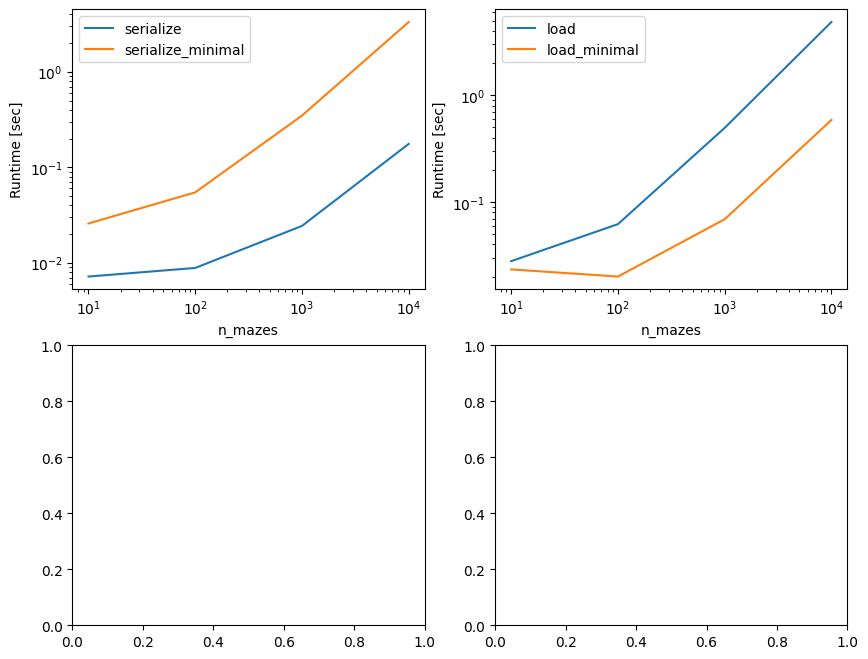

In [141]:
fig = plt.figure(figsize=(10,8))
fig.subplots(2,2)
ax = fig.axes[0]
speeds.loc[2:5, ['n_mazes', 'serialize', 'serialize_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[1]
speeds.loc[2:5, ['n_mazes', 'load', 'load_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')